In [63]:
import numpy as np
import sys
from scipy import sparse
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import networkx as nx
%matplotlib inline

# I. Load the data, clean it and extract usefull information

In [110]:
nodes = pd.read_csv("./NTDS_Data/census_and_vote_data.csv" )
migflow2015_county_nodeid_dist = pd.read_csv("./NTDS_Data/migflow2015_county_nodeid_dist.csv")

In [3]:
# drop useless columns : ori_county and des_county use FSPE code as indexes, we are using a inhouse indexing
mig_flow = migflow2015_county_nodeid_dist.drop(columns=["ori_county", "des_county", "dist_km"])

In [102]:
num_nodes = nodes.values.shape[0]
num_flows = mig_flow.shape[0]
print(num_nodes)


1838


# II. Create the Adjency matrix

In [77]:
A_total = np.zeros((num_nodes, num_nodes))
A_returns = np.zeros((num_nodes, num_nodes))
A_exemptions = np.zeros((num_nodes, num_nodes))
for i in range (0, num_flows) : 
    total = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_total[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i] + mig_flow["exemptions"][i]
    A_returns[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["returns"][i]/total
    A_exemptions[mig_flow["ori_id"][i] - 1, mig_flow["des_id"][i] -1] = mig_flow["exemptions"][i]/total

In [78]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    
    distance=squareform(pdist(X, 'euclidean'))
    print(np.mean(distance))
    weights=np.exp(-distance**2/(2*sigma*sigma))
    np.fill_diagonal(weights,0)
    plt.hist(weights.reshape(weights.shape[0]**2 ,1),bins=100)
    plt.title("distance treshold")
    plt.show()
    adjacency=weights
    adjacency[adjacency<epsilon]=0
    a=np.ones_like(adjacency)
    return adjacency

2.05213148790842


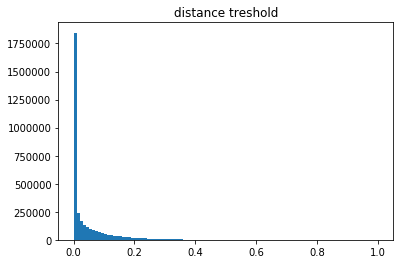

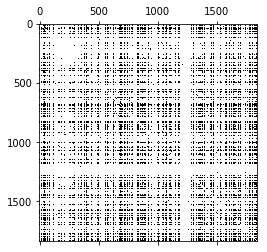

(1838, 1838)


In [94]:
adjacency = epsilon_similarity_graph(A_returns, sigma=2.05*0.25, epsilon=0.1)
plt.spy(adjacency)
plt.show()
print(adjacency.shape)

In [162]:
graph = nx.from_numpy_array(adjacency)
n = nodes["gop_pct_2016"].values
n[n >= 0.5] = 1
n[n < 0.5] = 0
n_id = nodes["node_id"].values
n_new = np.concatenate(([n_id], [n]),axis=0 )

node = pd.DataFrame(n_new.T, columns=["id", "result"])
node_props = node.to_dict()
for key in node_props:
    # print(key, node_props[key])
    nx.set_node_attributes(graph, node_props[key], key)



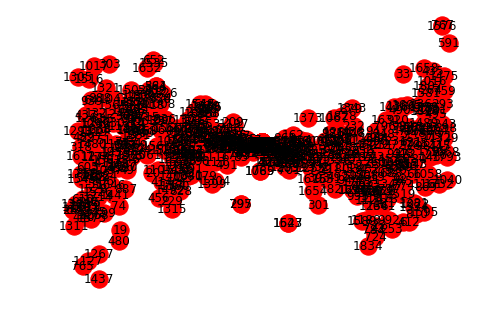

In [167]:
nx.draw_spectral(graph, with_labels=True)
nx.write_gexf(graph, 'result.gexf')